# Simple Neural Network learns sine function using JAX, Equinox and Optax

<img src="https://upload.wikimedia.org/wikipedia/commons/8/86/Google_JAX_logo.svg" width=150 />
<img src="https://optax.readthedocs.io/en/latest/_static/logo.svg" width=150 />

In [3]:
import jax
import jax.numpy as jnp
import equinox as eqx
import optax
import matplotlib.pyplot as plt
from typing import List

In [4]:
N_SAMPLES = 200
LAYERS = [1, 10, 10, 10, 1]
LEARNING_RATE = 0.1
N_EPOCHS = 30_000

In [5]:
key = jax.random.PRNGKey(0)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [6]:
key, xkey, ynoisekey = jax.random.split(key, 3)
x_samples = jax.random.uniform(xkey, (N_SAMPLES, 1), minval=0.0, maxval=2*jnp.pi)
y_samples = jnp.sin(x_samples) + jax.random.normal(ynoisekey, (N_SAMPLES, 1)) * 0.3

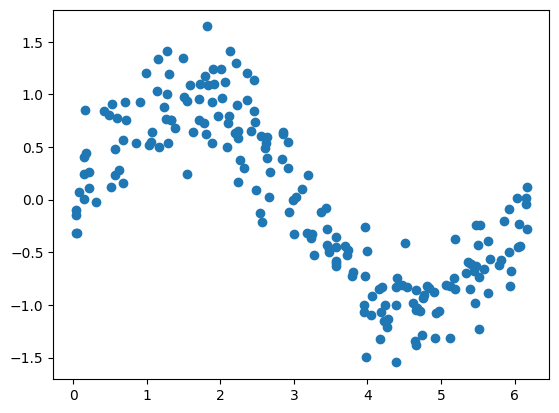

In [7]:
plt.scatter(x_samples, y_samples)

In [8]:
class SimpleMLP(eqx.Module):
    layers: List[eqx.nn.Linear]

    def __init__(self, layer_sizes, key):
        self.layers = []

        for (fan_in, fan_out) in zip(layer_sizes[:-1], layer_sizes[1:]):
            key, subkey = jax.random.split(key)
            self.layers.append(
                eqx.nn.Linear(fan_in, fan_out, use_bias=True, key=subkey)
            )
    
    def __call__(self, x):
        a = x
        for layer in self.layers[:-1]:
            a = jax.nn.sigmoid(layer(a))
        a = self.layers[-1](a)

        return a

In [9]:
model = SimpleMLP(LAYERS, key=key)

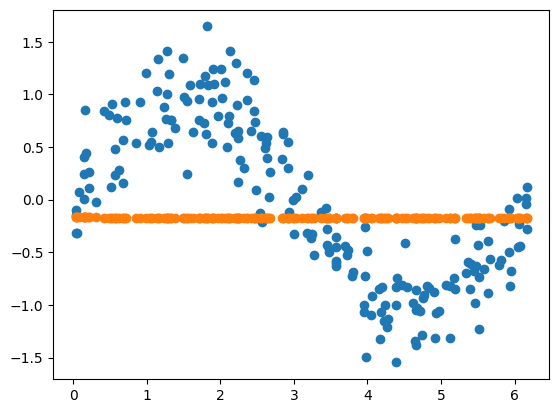

In [11]:
# Initial prediction
plt.scatter(x_samples, y_samples)
plt.scatter(x_samples, jax.vmap(model)(x_samples))

In [12]:
def model_to_loss(m, x, y):
    prediction = jax.vmap(m)(x)
    delta = prediction - y
    loss = jnp.mean(delta**2)
    return loss

In [13]:
model_to_loss(model, x_samples, y_samples)

Array(0.61819804, dtype=float32)

In [15]:
model_to_loss_and_grad = eqx.filter_value_and_grad(model_to_loss)

In [16]:
model_to_loss_and_grad(model, x_samples, y_samples)

(Array(0.61819804, dtype=float32),
 SimpleMLP(
   layers=[
     Linear(
       weight=f32[10,1],
       bias=f32[10],
       in_features=1,
       out_features=10,
       use_bias=True
     ),
     Linear(
       weight=f32[10,10],
       bias=f32[10],
       in_features=10,
       out_features=10,
       use_bias=True
     ),
     Linear(
       weight=f32[10,10],
       bias=f32[10],
       in_features=10,
       out_features=10,
       use_bias=True
     ),
     Linear(
       weight=f32[1,10],
       bias=f32[1],
       in_features=10,
       out_features=1,
       use_bias=True
     )
   ]
 ))

In [18]:
opt = optax.sgd(LEARNING_RATE)  # Here you could also use optax.adam(...)
opt_state = opt.init(eqx.filter(model, eqx.is_array))

In [20]:
@eqx.filter_jit
def make_step(m, opt_s, x, y):
    loss, grad = model_to_loss_and_grad(m, x, y)
    updates, opt_s = opt.update(grad, opt_s, m)
    m = eqx.apply_updates(m, updates)
    return m, opt_s, loss

In [21]:
# Training loop
loss_history = []
for epoch in range(N_EPOCHS):
    model, opt_state, loss = make_step(model, opt_state, x_samples, y_samples)
    loss_history.append(loss)

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, loss {loss}")

Epoch 0, loss 0.618198037147522
Epoch 100, loss 0.5929845571517944
Epoch 200, loss 0.5906002521514893
Epoch 300, loss 0.5868180394172668
Epoch 400, loss 0.5801002383232117
Epoch 500, loss 0.566866934299469
Epoch 600, loss 0.5378221869468689
Epoch 700, loss 0.46953481435775757
Epoch 800, loss 0.34839046001434326
Epoch 900, loss 0.280775249004364
Epoch 1000, loss 0.26581865549087524
Epoch 1100, loss 0.25935813784599304
Epoch 1200, loss 0.25403133034706116
Epoch 1300, loss 0.2487192302942276
Epoch 1400, loss 0.24320776760578156
Epoch 1500, loss 0.2374759465456009
Epoch 1600, loss 0.23156489431858063
Epoch 1700, loss 0.22554267942905426
Epoch 1800, loss 0.21948927640914917
Epoch 1900, loss 0.21348616480827332
Epoch 2000, loss 0.20760928094387054
Epoch 2100, loss 0.20192395150661469
Epoch 2200, loss 0.19648192822933197
Epoch 2300, loss 0.1913195699453354
Epoch 2400, loss 0.1864566057920456
Epoch 2500, loss 0.18189576268196106
Epoch 2600, loss 0.17762385308742523
Epoch 2700, loss 0.173613741

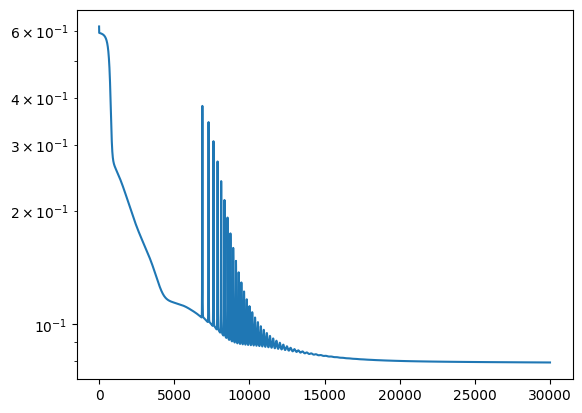

In [22]:
plt.plot(loss_history)
plt.yscale("log")

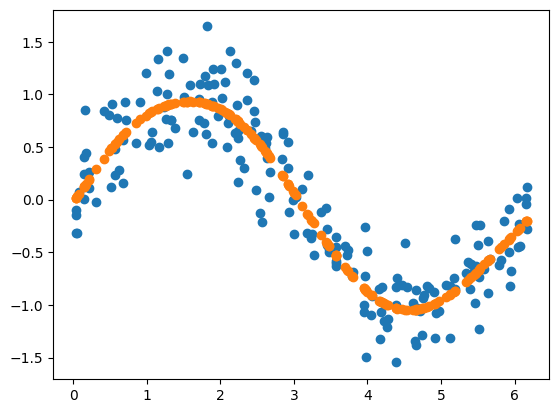

In [23]:
plt.scatter(x_samples, y_samples)
plt.scatter(x_samples, jax.vmap(model)(x_samples))